# Задание 8.

* Реализовать один из проекционный метод: метод Ритца.
* Сравнить решения при разных N (либо графически, либо выводить значения решений на достоточно частой сетке).

**Отчёт:** https://docs.google.com/document/d/1ELizfC3b-Z5zbc8Y0Cgkgp-HYfPG8pzsBZftJs21bmY/edit?usp=sharing

In [1]:
from typing import Callable
from math import exp

import numpy as np
from scipy import integrate
from scipy.special import eval_jacobi
import matplotlib.pyplot as plt

# Solution

In [2]:
def scalar_multiplication(f1, f2):
    return integrate.quad(lambda x: f1(x) * f2(x), -1, 1)[0]


def bilinear_form(f1, f2, df1, df2, p, r, Q):
    integral = integrate.quad(lambda x: p(x) * df1(x) * df2(x) + r(x) * f1(x) * f2(x), -1, 1)[0]
    return integral + Q(f1, f2)


def get_jacobi_polynomials_and_derivatives(n, k):
    P = [lambda x, N=i: eval_jacobi(N, k + 1, k + 1, x) for i in range(n - 1)]
    jacobi_polynomials = [lambda x, N=i: eval_jacobi(N, k, k, x) for i in range(n)]
    derivatives = [lambda x, N=i: 0 if N == 0 else (N + 2 * k + 1) * P[N - 1](x) / 2 for i in range(n)]

    return jacobi_polynomials, derivatives

# This function implements the Ritz method to solve a boundary value problem for a second-order ordinary 
# differential equation of the form: -(p(x) * u')' + r(x) * u = f(x), over the interval a < x < b. 
# The method approximates the solution u(x) as a series expansion in terms of basis functions, which 
# are often chosen from a set of orthogonal polynomials like Jacobi polynomials, indexed by 'k'.
#
# Assumptions:
# - p(x): A smooth function representing the coefficient of u''(x) in the differential equation. 
#         It is assumed to be non-negative (p(x) >= p0 > 0) over the interval, ensuring a well-posed problem.
# - r(x): A continuous function, representing the coefficient of u(x). It is assumed to be strictly positive 
#         (r(x) > 0) over the interval, typically ensuring the uniqueness of the solution.
# - f(x): The right-hand side function of the differential equation, defining the inhomogeneity of the problem.
# - Boundary Conditions:
#   - At x = -1: alpha1 * u(-1) - alpha2 * u'(-1) = 0. Here, alpha1 and alpha2 are constants, and their 
#     combination represents a mix of Dirichlet and Neumann conditions. The condition 
#     |alpha1| + |alpha2| != 0 ensures that the boundary condition is not trivial, and alpha1 * alpha2 >= 0 
#     implies that the coefficients do not contradict each other.
#   - At x = 1:  beta1 * u(1) - beta2 * u'(1) = 0. Similarly, beta1 and beta2 are constants for the boundary 
#     condition at x = 1, with the same restrictions as for alpha1 and alpha2.
#
# Parameters:
# - p, r, f: Callables representing the functions p(x), r(x), and f(x), respectively.
# - n: The number of terms in the series expansion, controlling the approximation's granularity.
# - alpha1, alpha2, beta1, beta2: Constants defining the mixed boundary conditions at x = -1 and x = 1.
# - k (optional): Index for the choice of basis functions, defaulting to 0. Higher values of k might 
#   correspond to more complex basis functions.
#
# Returns:
# - A callable representing the approximate solution u(x) to the differential equation.
def solve_using_ritz_method(p: Callable, r: Callable, f: Callable, n: int,
                            alpha1: float, alpha2: float, beta1: float, beta2: float, k=0) -> Callable:
    W, dW = get_jacobi_polynomials_and_derivatives(n, k)

    Q = lambda f1, f2: 0 if (alpha1 == 0 or alpha2 == 0) else (
        alpha1 * p(-1) * f1(-1) * f2(-1) / alpha2 + beta1 * p(1) * f1(1) * f2(1) / beta2
    )

    M = np.array([[bilinear_form(W[row], W[column], dW[row], dW[column], p, r, Q)
                   for column in range(n)] for row in range(n)])
    v = np.array([scalar_multiplication(f, w) for w in W])
    C = np.linalg.solve(M, v)

    return lambda x: sum(C[i] * W[i](x) for i in range(n))

# Tests

In [3]:
n = 3
p = lambda x: x + 2
r = lambda _: 10
f = lambda x: -exp(x) * (x + 3) + 10 * exp(x)
alpha1, alpha2 = 1, 1
beta1, beta2 = 1, 1

actual = solve_using_ritz_method(p, r, f, n, alpha1, alpha2, beta1, beta2)
expected = exp

assert (all([abs(actual(x) - expected(x)) < 3 for x in [-1 + 2 * i / 10 for i in range(n)]]))

# Experiments

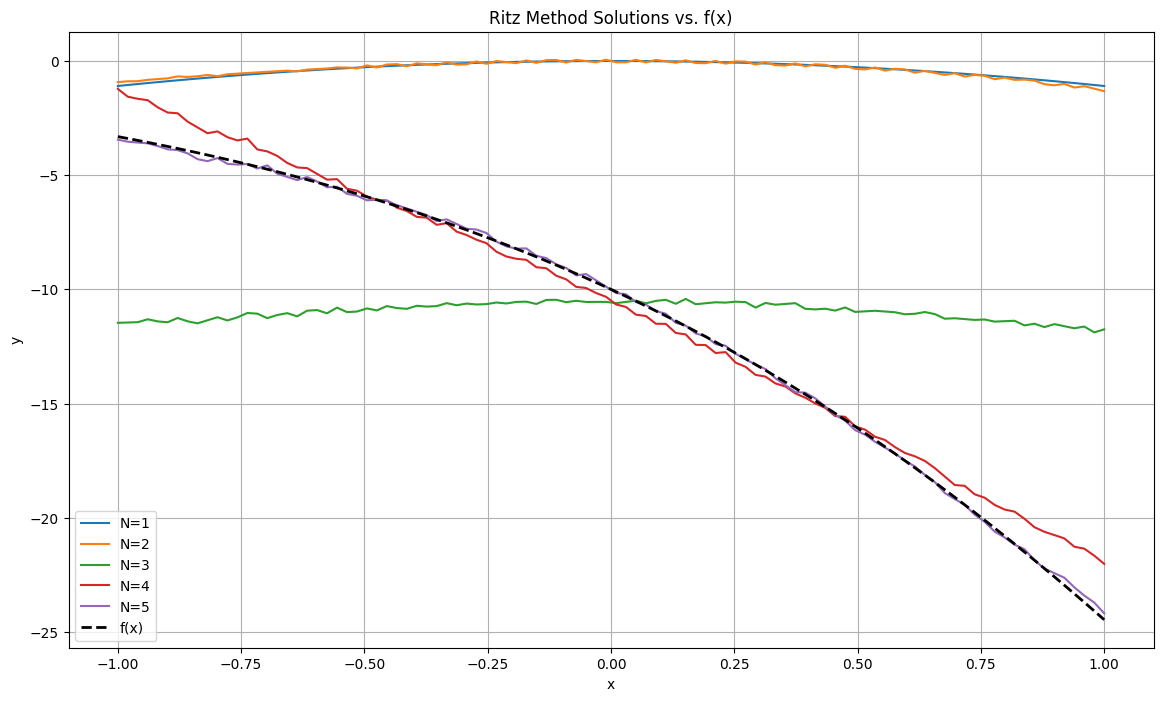

In [4]:
p = lambda _: 10
r = lambda x: x ** 2
f = lambda x: (x ** 2 - 10) * exp(x)
alpha1, alpha2 = 1, 1
beta1, beta2 = 1, 1
y = exp

N_values = range(1,6)

plt.figure(figsize=(14, 8))

def d(f):
    h = 1e-7
    return lambda x: (f(x + h) - f(x - h)) / (2 * h)

def left(p, r, u):
    return lambda x: -d(lambda x1: p(x1) * d(u)(x1))(x) + (lambda x2: r(x2) * u(x2))(x)

for N in N_values:
    x_grid = np.linspace(-1, 1, 100)

    # Solve using Ritz method
    ritz_solution = solve_using_ritz_method(p, r, f, N, alpha1, alpha2, beta1, beta2)

    plt.plot(x_grid, [left(p, r, ritz_solution)(x) for x in x_grid], label=f'N={N}')

# Plotting the analytical solution
analytical_solution = [f(x) for x in x_grid]
plt.plot(x_grid, analytical_solution, 'k--', label='f(x)', linewidth=2)

# Enhancing the plot
plt.title('Ritz Method Solutions vs. f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()